In [146]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [147]:
path_PF_S3 = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Clinical projects/TILES/PF_survey_fix/S3_app_surveys_updated.csv'

In [148]:
#read in csv from S3 bucket; psychologial felxibility EMAs in long form
data_PF_S3 = pd.read_csv(path_PF_S3)
data_PF_S3 = pd.DataFrame(data = data_PF_S3)
print('Original data_PF_S3 shape:\n', data_PF_S3.shape, '\n')
#ensure no replicate ID (211 participants in study)
print('Original data_PF_S3 unique IDs:\n', data_PF_S3['participant_id'].unique().shape, '\n')
#how much missing data is there?
print('Original data_PF_S3 missing value counts:\n', data_PF_S3.isnull().sum(), '\n')
#what is the data type of each column?
print('Original data_PF_S3 data types:\n', data_PF_S3.info(), '\n')
#what is the participant response rate across the entire study?
print('Non-response rate over all PF surveys:\n', data_PF_S3.isnull().sum().max() / data_PF_S3.shape[0] * 100, '%')
#add a binary column for if survey was completed (1) or not (0)
data_PF_S3['completed'] = np.where(data_PF_S3['results_updated'].isnull(), 0, 1)

Original data_PF_S3 shape:
 (14628, 11) 

Original data_PF_S3 unique IDs:
 (211,) 

Original data_PF_S3 missing value counts:
 survey_id                 0
participant_id            0
survey_type               0
survey_dt                 0
delivered_ts_utc          0
started_ts_utc         3850
started_ts_offset      3850
completed_ts_utc       3850
completed_ts_offset    3850
ingested_ts_utc        3850
results_updated        3850
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14628 entries, 0 to 14627
Data columns (total 11 columns):
survey_id              14628 non-null object
participant_id         14628 non-null object
survey_type            14628 non-null object
survey_dt              14628 non-null object
delivered_ts_utc       14628 non-null object
started_ts_utc         10778 non-null object
started_ts_offset      10778 non-null object
completed_ts_utc       10778 non-null object
completed_ts_offset    10778 non-null object
ingested_ts_utc        10778 non-nul

In [149]:
#change dates from objects to datetimes
data_PF_S3['survey_dt'] = data_PF_S3['survey_dt'].astype('datetime64')
data_PF_S3['delivered_ts_utc'] = data_PF_S3['delivered_ts_utc'].astype('datetime64[ns]')
data_PF_S3['started_ts_utc'] = data_PF_S3['started_ts_utc'].astype('datetime64[ns]')
data_PF_S3['completed_ts_utc'] = data_PF_S3['completed_ts_utc'].astype('datetime64[ns]')
data_PF_S3['ingested_ts_utc'] = data_PF_S3['ingested_ts_utc'].astype('datetime64[ns]')

#confirm change 
print(data_PF_S3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14628 entries, 0 to 14627
Data columns (total 12 columns):
survey_id              14628 non-null object
participant_id         14628 non-null object
survey_type            14628 non-null object
survey_dt              14628 non-null datetime64[ns]
delivered_ts_utc       14628 non-null datetime64[ns]
started_ts_utc         10778 non-null datetime64[ns]
started_ts_offset      10778 non-null object
completed_ts_utc       10778 non-null datetime64[ns]
completed_ts_offset    10778 non-null object
ingested_ts_utc        10778 non-null datetime64[ns]
results_updated        10778 non-null object
completed              14628 non-null int32
dtypes: datetime64[ns](5), int32(1), object(6)
memory usage: 1.3+ MB
None


In [150]:
print('data_PF_S3 shape:\n', data_PF_S3.shape, '\n')
print('data_PF_S3 unique survey_id shape:\n', data_PF_S3['survey_id'].unique().shape, '\n')
print('data_PF_S3 unique participant_id shape:\n', data_PF_S3['participant_id'].unique().shape, '\n')
print('data_PF_S3 unique survey_types:\n', data_PF_S3['survey_type'].value_counts(), '\n')

#what is the participant response rate for each survey type?
print('Non-response rate over psych_flex survey:\n', data_PF_S3[data_PF_S3['survey_type'] == 'psych_flex'].isnull().sum().max() /
      data_PF_S3[data_PF_S3['survey_type'] == 'psych_flex'].shape[0] * 100, '%')
print('Non-response rate over engage_psycap survey:\n', data_PF_S3[data_PF_S3['survey_type'] != 'psych_flex'].isnull().sum().max() /
      data_PF_S3[data_PF_S3['survey_type'] == 'psych_flex'].shape[0] * 100, '%')

data_PF_S3 shape:
 (14628, 12) 

data_PF_S3 unique survey_id shape:
 (14628,) 

data_PF_S3 unique participant_id shape:
 (211,) 

data_PF_S3 unique survey_types:
 psych_flex       10450
engage_psycap     4178
Name: survey_type, dtype: int64 

Non-response rate over psych_flex survey:
 26.181818181818183 %
Non-response rate over engage_psycap survey:
 10.660287081339712 %


In [151]:
#split off the psych_flex survey
data_PF_S3_PFonly = data_PF_S3[data_PF_S3['survey_type'] == 'psych_flex']
print(data_PF_S3_PFonly.shape)

(10450, 12)


In [152]:
#compute time between when survey is sent and when participant starts the survey
data_PF_S3_PFonly['start_delay'] = data_PF_S3_PFonly['started_ts_utc'] - data_PF_S3_PFonly['delivered_ts_utc']
#compute time between when survey is sent and when participant starts the survey
data_PF_S3_PFonly['time_to_complete'] = data_PF_S3_PFonly['completed_ts_utc'] - data_PF_S3_PFonly['started_ts_utc']

In [153]:
#each participant should have 50 survey entries
data_PF_S3_PFonly['participant_id'].value_counts()

c7acafcf-f5dd-411e-b90c-988279852fb8    60
803be457-cee4-4f3f-9540-ff574c57c697    60
fae38580-1e2d-4491-9de5-7b75703ba4ce    60
9519432e-bf05-4f6c-80d7-f61e930f14ba    60
0adb7679-9d26-46e7-a134-11da293910f3    60
db2bffd9-c5b5-4fed-9d55-09a087ce0e6e    52
6ceb4ef3-6578-45cc-bc02-fa97614313e1    51
e05bec91-93e2-4b23-9d4f-ae79dade8451    51
a2676b6d-a28f-46bf-b3f0-6a2e735ae251    51
df3a6b7a-7e27-4003-beea-2cb5cf08da83    51
4b8d9e5c-1e51-4a1d-81c9-b3911f623c08    50
7c885f26-7923-41a3-847e-c971eafee8d4    50
b318de0d-0b0a-4ba8-a7be-9fcf7b9d8c67    50
d046a3ef-1402-4530-855c-481798c41ccd    50
69c89ffd-abcc-445b-9168-d2c42ab4e7ee    50
8307ff6e-f582-49b0-81cc-39fe9966d097    50
fabef151-53c8-4a46-9897-0180868a53f5    50
e5594e40-9999-45b6-ac2f-bbd063395cd0    50
f9264a9d-99d8-4937-8bda-eb620c0c1ed7    50
a1623554-43d6-4038-b28a-bd74a96b9c97    50
0ebe238f-34a9-47f5-a04b-5b059e45e4a5    50
e027002a-cf96-4132-a4ac-2003e945258d    50
a2664330-dcfa-4d43-a788-8904343b6a00    50
a70d820b-e8

In [158]:
data_PF_S3_PFonly[data_PF_S3_PFonly['participant_id'] == 'f9264a9d-99d8-4937-8bda-eb620c0c1ed7']

,survey_id,participant_id,survey_type,survey_dt,delivered_ts_utc,started_ts_utc,started_ts_offset,completed_ts_utc,completed_ts_offset,ingested_ts_utc,results_updated,completed,start_delay,time_to_complete
14054,8bebc4dd-1c26-4b4e-9cb7-5658be7c7efc,f9264a9d-99d8-4937-8bda-eb620c0c1ed7,psych_flex,2018-04-09,2018-04-09 20:26:13,2018-04-10 00:07:24,"tzoffset(None, -25200)",2018-04-10 05:23:45,"tzoffset(None, -25200)",2018-04-10 05:20:47.188034,"{'8': 3, '6': 4, '14': 4, '15': 4, '12': 5, '3...",1,03:41:11,05:16:21
14055,9645bdbc-44f3-4075-8d6e-c60e48645237,f9264a9d-99d8-4937-8bda-eb620c0c1ed7,psych_flex,2018-04-10,2018-04-10 19:39:38,2018-04-10 23:43:08,"tzoffset(None, -25200)",2018-04-11 00:46:22,"tzoffset(None, -25200)",2018-04-11 00:46:23.574672,"{'8': 2, '6': 4, '14': 3, '15': 5, '12': 4, '3...",1,04:03:30,01:03:14
14056,9644e852-f808-47cf-8df4-eb618b4db751,f9264a9d-99d8-4937-8bda-eb620c0c1ed7,psych_flex,2018-04-11,2018-04-11 23:14:18,2018-04-12 05:18:56,"tzoffset(None, -25200)",2018-04-12 05:27:09,"tzoffset(None, -25200)",2018-04-12 05:27:11.643584,"{'8': 3, '6': 4, '14': 3, '15': 4, '12': 4, '3...",1,06:04:38,00:08:13
14058,bd869949-44df-464d-888b-293e9f70f81e,f9264a9d-99d8-4937-8bda-eb620c0c1ed7,psych_flex,2018-04-13,2018-04-13 18:27:52,2018-04-13 21:01:56,"tzoffset(None, -25200)",2018-04-13 21:13:22,"tzoffset(None, -25200)",2018-04-13 21:13:23.511418,"{'12': 4, '5': 5, '1': '2', '13': 4, '14': 4, ...",1,02:34:04,00:11:26
14059,a5df32ed-fbbf-42bb-951e-5b2932e80742,f9264a9d-99d8-4937-8bda-eb620c0c1ed7,psych_flex,2018-04-14,2018-04-14 22:30:51,2018-04-15 03:32:51,"tzoffset(None, -25200)",2018-04-15 03:34:44,"tzoffset(None, -25200)",2018-04-15 03:34:45.518505,"{'12': 3, '5': 4, '1': '0', '13': 4, '14': 4, ...",1,05:02:00,00:01:53
14062,930c958e-17bd-4488-99c5-105c69df5a6b,f9264a9d-99d8-4937-8bda-eb620c0c1ed7,psych_flex,2018-04-17,2018-04-18 00:52:18,2018-04-18 00:55:14,"tzoffset(None, -25200)",2018-04-18 00:58:20,"tzoffset(None, -25200)",2018-04-18 00:58:22.399246,"{'15': 3, '6': 4, '4': 4, '11': 4, '9': 4, '8'...",1,00:02:56,00:03:06
14064,641c4362-2ba8-48b4-91b3-fefcaf9ff8ce,f9264a9d-99d8-4937-8bda-eb620c0c1ed7,psych_flex,2018-04-19,2018-04-19 22:25:35,2018-04-19 22:41:05,"tzoffset(None, -25200)",2018-04-19 22:43:18,"tzoffset(None, -25200)",2018-04-19 22:43:22.035235,"{'14': 4, '1': '6', '15': 4, '12': 4, '6': 4, ...",1,00:15:30,00:02:13
14065,429955d8-b1a2-4f0b-a07c-926a95aa0694,f9264a9d-99d8-4937-8bda-eb620c0c1ed7,psych_flex,2018-04-20,2018-04-20 18:00:57,2018-04-20 21:23:52,"tzoffset(None, -25200)",2018-04-20 21:31:05,"tzoffset(None, -25200)",2018-04-21 04:05:39.864058,"{'14': 4, '1': '0', '15': 4, '12': 4, '6': 4, ...",1,03:22:55,00:07:13
14066,d2716dc2-28b7-4cd7-a0ee-bf241217f630,f9264a9d-99d8-4937-8bda-eb620c0c1ed7,psych_flex,2018-04-21,2018-04-22 00:47:41,2018-04-22 01:11:41,"tzoffset(None, -25200)",2018-04-22 01:17:36,"tzoffset(None, -25200)",2018-04-22 01:17:41.550676,"{'14': 4, '1': '7', '15': 4, '12': 4, '6': 4, ...",1,00:24:00,00:05:55
14067,1e4f5f24-5a94-4ffd-9771-7415a6ce499a,f9264a9d-99d8-4937-8bda-eb620c0c1ed7,psych_flex,2018-04-22,2018-04-22 21:57:23,2018-04-22 22:49:59,"tzoffset(None, -25200)",2018-04-22 22:53:54,"tzoffset(None, -25200)",2018-04-22 22:53:59.265620,"{'14': 4, '1': '9', '15': 4, '12': 4, '6': 4, ...",1,00:52:36,00:03:55


In [145]:
x = (data_PF_S3_PFonly['results_updated'].loc[44].split(','))
print(x)
questions = np.arange(15)
for number in questions:
    if re.search(r'1', x[0]):
        print(3)

["{'11': 5", " '12': 5", " '9': 3", " '7': 4", " '3': 4", " '4': 5", " '8': 4", " '13': 4", " '10': 5", " '1': 0", " '15': 5", " '6': 4", " '14': 4", " '5': 4", " '2': [1", ' 3', ' 5', ' 7]}']
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


<function matplotlib.pyplot.show(*args, **kw)>

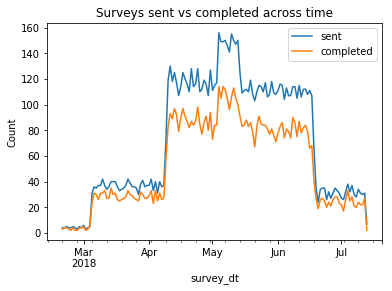

In [12]:
#number of participants sent surveys across time
ax = data_PF_S3_PFonly.groupby('survey_dt')['participant_id'].count().plot()
#number of participants completed surveys across time
ax = data_PF_S3_PFonly[data_PF_S3_PFonly['completed'] == 1].groupby('survey_dt')['completed'].count().plot()
plt.legend(('sent', 'completed'))
plt.title('Surveys sent vs completed across time')
ax.set_ylabel('Count')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

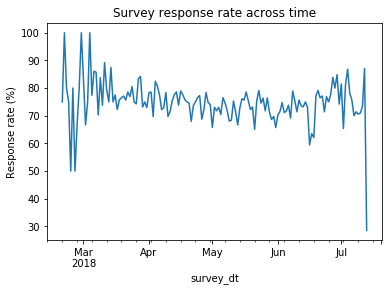

In [14]:
ax = (data_PF_S3_PFonly[data_PF_S3_PFonly['completed'] == 1].groupby('survey_dt')['participant_id'].count() /
 data_PF_S3_PFonly.groupby('survey_dt')['participant_id'].count()*100).plot()

ax.set_ylabel('Response rate (%)')
plt.title('Survey response rate across time')
plt.show